In [21]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
import paco.processing.fastpaco as fastPACO

from paco.util.util import *
import cv2 as cv2
from astropy.convolution import convolve, Gaussian2DKernel, AiryDisk2DKernel
from astropy.modeling.models import Gaussian2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from multiprocessing import Pool

# MC Parameters
nFrames = 10
angle = 60
angles = np.linspace(0,angle,nFrames)
psig = (30,30)
nTrials = 5
nProcess = 4

This notebook will generate a series of image stacks with gaussian distributed noise backgrounds. Multiple MC trials are run to determine the distribution of the PACO outputs.

In [22]:
def GenerateImageStack(nFrames,angles,signalStrength,noiseLevel,dim = 100):  
    # Hardcoded source location
    p0 = (30,30)
    mean = 0

    images = [np.reshape(np.random.normal(mean, noiseLevel, dim**2), (dim,dim)) for j in range(nFrames)]
    X,Y = np.meshgrid(np.arange(-dim/2, dim/2),np.arange(-dim/2, dim))
    xx, yy = np.meshgrid(np.arange(-30, dim-30),np.arange(-30, dim-30))
    s = gaussian2d(xx,yy,signalStrength/np.sqrt(nFrames), 2)

    #images_signal = [i + s for i in images]
    rot_noise = np.array([rotateImage(images[j], angles[j]) for j in range(nFrames)])
    rot_sigs = np.array([rotateImage(s, angles[j]) for j in range(nFrames)])
    rot_images = np.array([rot_noise[j] + rot_sigs[j] for j in range(nFrames)])
    return rot_images

def GetImPatch(im,px,width):
        k = int(width/2)
        nx, ny = np.shape(im.shape)[:2]
        if px[0]+k > nx or px[0]-k < 0 or px[1]+k > ny or px[1]-k < 0:
            #print("pixel out of range")
            return None
        patch = im[i][int(px[0])-k:int(px[0])+k, int(px[1])-k:int(px[1])+k]
        return patch

def pacoTrial(im_stack):
    fp = fastPACO.FastPACO(patch_size = 49,
                       angles = angles)
    im_stack = GenerateImageStack(nFrames,angles,5.0,1.0)
    fp.setImageSequence(im_stack)
    a,b = fp.PACO(scale = 1, 
                  model_params={"sigma":2.0})
    est = fp.fluxEstimate(p0 = psig,
                         eps = 0.05,
                         params = {"sigma":2.0},
                         initial_est = 0.0,
                         scale = 1)
    return (a,b,est)

In [23]:
trials = [GenerateImageStack(nFrames,angles,5.0,1.0) for i in range(nTrials)]

pool = Pool(processes = nProcess)
data = pool.map(pacoTrial,trials)
pool.close()
pool.join()


Precomputing Statistics...
Precomputing Statistics...
Precomputing Statistics...
Precomputing Statistics...


Process ForkPoolWorker-23:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-21:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))

KeyboardInterrupt

Process ForkPoolWorker-24:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
 

In [12]:
alist,blist,flux = [],[],[]
for d in data:
    alist.append(d[0])
    blist.append(d[1])
    flux.append(d[2])
alist = np.array(alist)
blist = np.array(blist)
flux = np.array(flux)

In [13]:
var = []
peak = []
snr = []
var_full = []
# Should do this with numpy slicing...
for i in range(nTrials):
    var.append(alist[i][30][30])
    peak.append(blist[i][30][30]/ alist[i][30][30])
    snr.append(blist[i][30][30]/ np.sqrt(alist[i][30][30]))
    var_full.append(np.var(blist[i][30][30]/ alist[i][30][30]))
var = np.array(var)
peak = np.array(peak)
snr = np.array(snr)
var_full = np.array(var_full)

In [17]:
print(np.var(peak),np.mean(var))

0.0 0.3689956175597856
[0.36899562 0.36899562]


/home/evert/.local/share/virtualenvs/PACO-4ds6DMDq/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/evert/.local/share/virtualenvs/PACO-4ds6DMDq/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


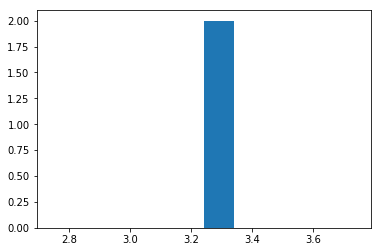

In [15]:
plt.figure()
plt.hist(peak)
plt.show()